# Basic Iterative Method

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output

# Import helper functions
from modules.helper import *
from modules.attacks import apply_BIM
from modules.dataset import ImageNetSubset

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack

BIM requires the following function, which clips pixel values of an image $X^\prime$:

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = 1$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

In [4]:
def compare_examples_bim(alpha, epsilon, idx, folder=None):
    '''
    Generates an example using BIM. Prints infos and plots clean and adversarial image side-by-side.
    
    Inputs:
    alpha   -- Hyperparameter for BIM
    epsilon -- Hyperparameter for BIM
    idx     -- Index of sample   
    folder  -- If given image will be saved to this folder
    '''
    
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    #num_iterations = 4
    print("Number of iterations: " + str(num_iterations))
    
    
    # Get data
    image_clean, target_class = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_class.unsqueeze_(0)

    # Predict clean example
    labels, confidences, gradient = predict(model, image_clean, target_class, return_grad=True)
    label_clean = labels[0]
    conf_clean = confidences[0]
    
    # Compute adversarial image and predict for it.    
    image_adv = apply_BIM(model, mean, std, image_clean, label_clean, alpha, epsilon, num_iterations=num_iterations)
    labels, confidences, _ = predict(model, image_adv, target_class, return_grad=False)
    label_adv = labels[0]
    conf_adv = confidences[0]
    
    
    # Plot
    summarize_attack(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_class, idx,
                        folder=folder)

## Comparison paper p.5
FGSM vs. BIM when including false initial predictions.

In [ ]:
# FGSM

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

## 2. Attack

Number of iterations: 1
			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				14.79%



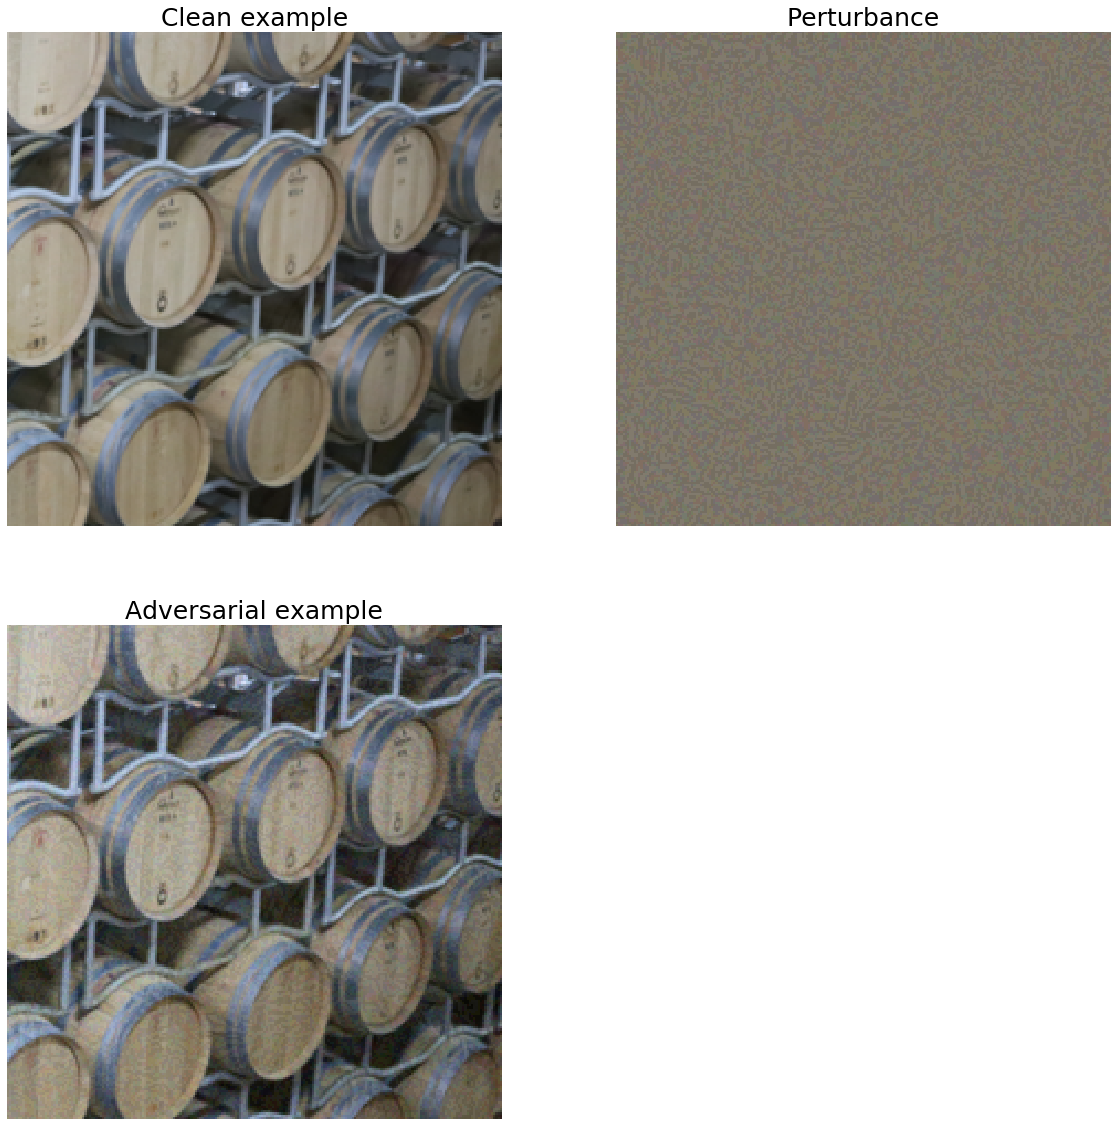

In [5]:
alpha = 1
epsilon = 6/255

compare_examples_bim(alpha, epsilon, 766, folder=None)

## 0. Introduction

## 1. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 1.1 Intervals of initial confidences

In [30]:
def confidence_interval(min_confidence, max_confidence):
    '''
    Splits predictions on clean dataset into provided interval of confidences. Then crafts adversarial examples
    from it for correct initital predictions and fixed epsilons and returns confidences, top1 and top5
    for those.
    
    Inputs:
    min_confidence -- Minimum confidence to consider
    max_confidence -- Maximum confidence to consider
    
    Returns:
    result         -- Dataframe with top1, top5 and confidence for prediction
    '''
    
    # Set perturbation
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255,
                4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]
    
    alpha = 0.5
    
    # Take list results
    result = pd.read_csv("results/Clean-Predictions.csv", index_col=0)

    # Filter correct predictions
    samples = result.loc[result["Accuracy Top 1"] == 1]

    # Filter confidence
    samples = samples.loc[samples["Confidence 1"] > min_confidence]
    samples = samples.loc[samples["Confidence 1"] <= max_confidence]

    # Get samples
    samples = list(samples.index)

    # Predict
    accurcy_top1 = []
    accurcy_top5 = []
    confidence_adversarial = []

    for epsilon in epsilons: 
        
        # Compute number of iterations
        num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
        
        acc_sub_adver_top1 = []
        acc_sub_adver_top5 = []
        conf_sub_adver = []    
        i = 1

        for sample in samples:
            image_clean, target_class = data_loader.dataset[sample]
            image_clean.unsqueeze_(0)
            target_class.unsqueeze_(0)

            clear_output(wait=True)       
            print("Running for epsilon {:.2f}".format(epsilon*255))
            print("Sample: "+ str(i) + " of " + str(len(samples)))
            print("Accuracy top 1 adversarial: {:.2f}".format(np.mean(acc_sub_adver_top1)))
            print("Accuracy top 5 adversarial: {:.2f}".format(np.mean(acc_sub_adver_top5)))
            print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))

            # Predict with clean image
            predicted_classes, _, gradient = predict(model, image_clean, target_class, return_grad=True)
            

            # Generate adversarial example only if initial prediction was correct
            if predicted_classes[0] == target_class.squeeze().numpy():            
                
                # Predict with adversarial image
                image_adversarial = apply_BIM(model, mean, std, image_clean, target_class, alpha, epsilon, num_iterations=num_iterations)
                predicted_classes, confidences, _ = predict(model, image_adversarial, target_class, return_grad=False)
                

                if predicted_classes[0] == target_class.squeeze().numpy():
                    acc_sub_adver_top1.append(1)
                else:
                    acc_sub_adver_top1.append(0)
                    
                if target_class.squeeze().numpy() in predicted_classes:
                    acc_sub_adver_top5.append(1)
                    
                else:
                    acc_sub_adver_top5.append(0)
                    
                conf_sub_adver.append(confidences[0])

            i += 1

        # Add accuracies and confidences for clean and adversarial example
        accurcy_top1.append(np.mean(acc_sub_adver_top1))
        accurcy_top5.append(np.mean(acc_sub_adver_top5))
        confidence_adversarial.append(np.mean(conf_sub_adver))

    # Save results
    result = pd.DataFrame()
    epsilon = np.array(epsilons) * 255
    result["Epsilon_255"] = epsilon
    result["Accuracy Top 1"] = accurcy_top1
    result["Accuracy Top 5"] = accurcy_top5
    result["Confidence"] = confidence_adversarial
    result.to_csv("results/BIM-Conf" + str(int(min_confidence*100)) + ".csv") 
    
    return result

In [18]:
max_confidence = 0.60
min_confidence = 0.40

result = confidence_interval(min_confidence, max_confidence)

Running for epsilon 60.00
Sample: 155 of 155
Accuracy top 1 adversarial: 0.03
Accuracy top 5 adversarial: 0.06
Confidence adversarial: 0.28


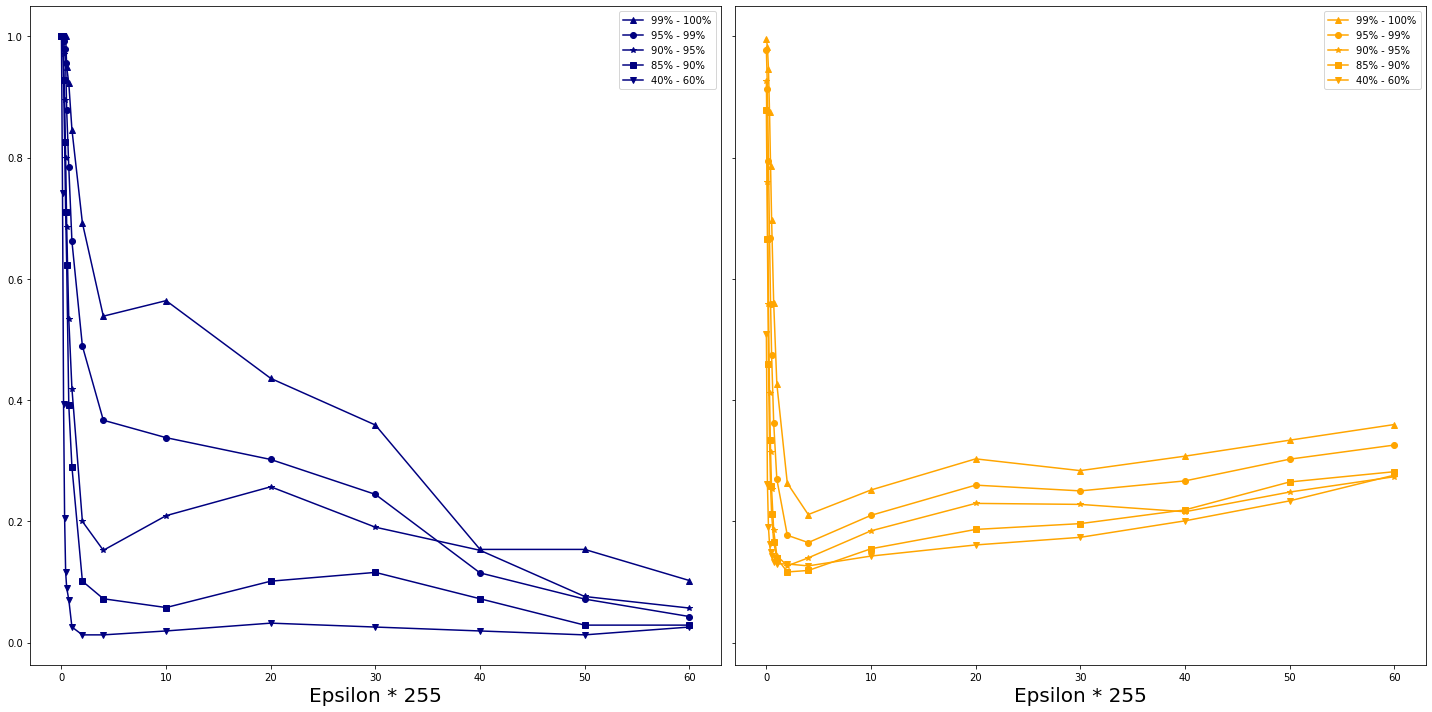

In [19]:
### PLOT 1
####### PLOT 3
# Load data
result_99 = pd.read_csv("results/BIM-Conf99.csv")
result_95 = pd.read_csv("results/BIM-Conf95.csv")
result_90 = pd.read_csv("results/BIM-Conf90.csv")
result_85 = pd.read_csv("results/BIM-Conf85.csv") 
result_40 = pd.read_csv("results/BIM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
#axs[0].set_title("Accuracies", fontsize=25)
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
#axs[1].set_title("Confidences", fontsize=25)
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/BIM/Accuracies_Confidences.pdf")
fig.savefig("plots/BIM/Accuracies_Confidences.png")

In [9]:
apply_BIM?

## 2. Indivdual Images

In [11]:
def get_confidence_acc_class(epsilon, sample):
    '''
    ...
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    '''
    
    # Hyperparameter
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    alpha = 1
    
    
    # Get data
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)

    # Predict clean example
    _, _, gradient = predict(model, image_clean, class_index, return_grad=True)
              
    # Compute adversarial image and predict for it.
    image_adv = apply_BIM(model, mean, std, image_clean, class_index, alpha, epsilon, num_iterations=num_iterations)    
    predicted_classes, confidences, _ = predict(model, image_adv, class_index, return_grad=False)
    
    
    if predicted_classes[0] == class_index.squeeze().numpy():
        acc2 = 1
    else: 
        acc2 = 0
        
    conf_adv = confidences[0]
    
    
    class_name_adversarial = idx_to_name(predicted_classes[0])
        
    return conf_adv, acc2, class_name_adversarial

In [38]:
def analyze_fgsm_conf(sample, epsilon_conf, save_plot=False):
    '''
    Generates 4 plots: Image, conf over epsilon, top 5 conf for clean image, top 5 conf for adversarial image.
    
    '''  

    # Get data
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)

    # Predict clean example
    _, confidences_clean, gradient = predict(model, image_clean, class_index, return_grad=True)
    
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255, 3/255, 4/255, 5/255, 
                6/255, 8/255, 10/255, 12/255, 14/255, 16/255, 18/255, 20/255]
    alpha = 1

    conf_list = []
    acc_list = []

    print("Epsilon \t Accuracy \t Confidence \t Label")

    for epsilon in epsilons:
        conf_adv, acc, predicted_label = get_confidence_acc_class(epsilon, sample)
        conf_list.append(conf_adv)
        acc_list.append(acc)
        print(str(epsilon*255) + "\t\t\t" + str(acc) + "\t" + str(conf_adv) + "\t" + predicted_label) 
    
    # Compute top 5 confidences for selected epsilon
    ## Number of iterations
    num_iterations = int(np.min([np.ceil(epsilon_conf*4), np.ceil(1.25+epsilon_conf)]))
    image_adv = apply_BIM(model, mean, std, image_clean, class_index, alpha, epsilon_conf, num_iterations=num_iterations)    
    
    _, confidences_adv, _ = predict(model, image_adv, class_index, return_grad=False)
    
     
    # Plot
    samples = [1, 2, 3, 4, 5]
    
    fig, axs = plt.subplots(1, 4, figsize=(20,5))

    ## First image: Clean image
    im = show_tensor_image(image_clean)

    axs[0].imshow(im)
    axs[0].axis('off')

    ## Second image: Confidence dist over epsilon and correct/incorrect
    axs[1].plot(np.array(epsilons)*255, conf_list, "-^", color='orange', label='Confidence')
    axs[1].plot(np.array(epsilons)*255, acc_list, "s", color='navy', label='1: Corr, 0: False')
    axs[1].set_ylim(0, 1.1)
    axs[1].set_xlabel("Epsilon *255", fontsize=10)
    axs[1].legend()

    ## Third image: Clean image top 5 confidence
    axs[2].bar(samples, confidences_clean, color='orange')
    axs[2].set_ylim(0, 1.1)
    axs[2].set_xlabel("Epsilon *255", fontsize=10)

    ## Fourth image: Adversarial image selected epsilon top 5 confidence
    axs[3].bar(samples, confidences_adv, color='orange')
    axs[3].set_ylim(0, 1.1)
    axs[3].set_xlabel("Epsilon *255", fontsize=10)
    
    if save_plot is True:
        fig.tight_layout()
        fig.savefig("plots/BIM/Individual_Images-Sample_" + str(sample) + ".png")

### 2.1 Confidence and correct/false class over epsilon for individual images
Can you find one which:
- Cannot be forced to change the class
- Changes class and then changes back?
- Has higher adversarial confidence than initial confidence

In [20]:
# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [1/255, 2/255, 4/255, 6/255, 8/255, 10/255]


result = pd.DataFrame()

for epsilon in epsilons:   
    conf = []
    
    for idx in range(1000):
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print(idx+1)
        conf_adv, acc, label_adv = get_confidence_acc_class(epsilon, idx)
        
        if acc == 1:
            conf.append(conf_adv)

        else:
            conf.append(0)

    result["Epsilon " + str(int(epsilon*255))] = conf

#result.to_csv("results/BIM-accuracies-corr_only.csv")

Epsilon 10.0
1000


In [21]:
result = pd.read_csv("results/BIM-accuracies-corr_only.csv", index_col=0)
result

,Epsilon 1,Epsilon 2,Epsilon 4,Epsilon 6,Epsilon 8,Epsilon 10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.480923,0.391498,0.163807,0.157987,0.038325,0.0
3,0.000000,0.101448,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
996,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
998,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
re

#### 2.1.1 Predicted class invariant

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.9970818	honeycomb
0.2			1	0.99311674	honeycomb
0.3			1	0.9845147	honeycomb
0.4			1	0.97344714	honeycomb
0.5			1	0.96036625	honeycomb
0.7			1	0.961242	honeycomb
1.0			1	0.9775779	honeycomb
2.0			1	0.9843091	honeycomb
3.0			1	0.98188686	honeycomb
4.0			1	0.9745871	honeycomb
5.0			1	0.9695175	honeycomb
6.0			1	0.9760149	honeycomb
8.0			1	0.98728776	honeycomb
10.0			1	0.99186313	honeycomb
12.0			1	0.9927966	honeycomb
14.0			1	0.9946742	honeycomb
16.0			1	0.9933483	honeycomb
18.0			1	0.9926542	honeycomb
20.0			1	0.9918544	honeycomb


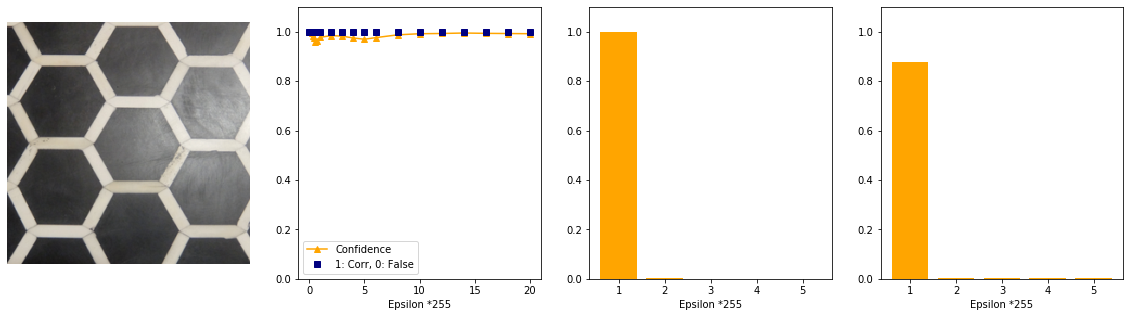

In [35]:
sample = 132
epsilon_conf = 4/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)


# Class doesn't change.
# Confidence incrreases again to almost initial level for higher epsilon. Why? How does it behave for other attack
# methods?

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8916601	oystercatcher, oyster catcher
0.1			1	0.7043278	oystercatcher, oyster catcher
0.2			1	0.5781431	oystercatcher, oyster catcher
0.3			1	0.5201387	oystercatcher, oyster catcher
0.4			1	0.4867911	oystercatcher, oyster catcher
0.5			1	0.4481157	oystercatcher, oyster catcher
0.7			1	0.34667462	oystercatcher, oyster catcher
1.0			1	0.33369938	oystercatcher, oyster catcher
2.0			1	0.3457879	oystercatcher, oyster catcher
3.0			1	0.4197726	oystercatcher, oyster catcher
4.0			1	0.38850176	oystercatcher, oyster catcher
5.0			1	0.39053503	oystercatcher, oyster catcher
6.0			1	0.4520925	oystercatcher, oyster catcher
8.0			1	0.3223948	oystercatcher, oyster catcher
10.0			1	0.40691918	oystercatcher, oyster catcher
12.0			1	0.4293065	oystercatcher, oyster catcher
14.0			1	0.53579426	oystercatcher, oyster catcher
16.0			1	0.52118415	oystercatcher, oyster catcher
18.0			1	0.38072422	oystercatcher, oyster catcher
20.0			1	0.49429342	oystercatcher, oy

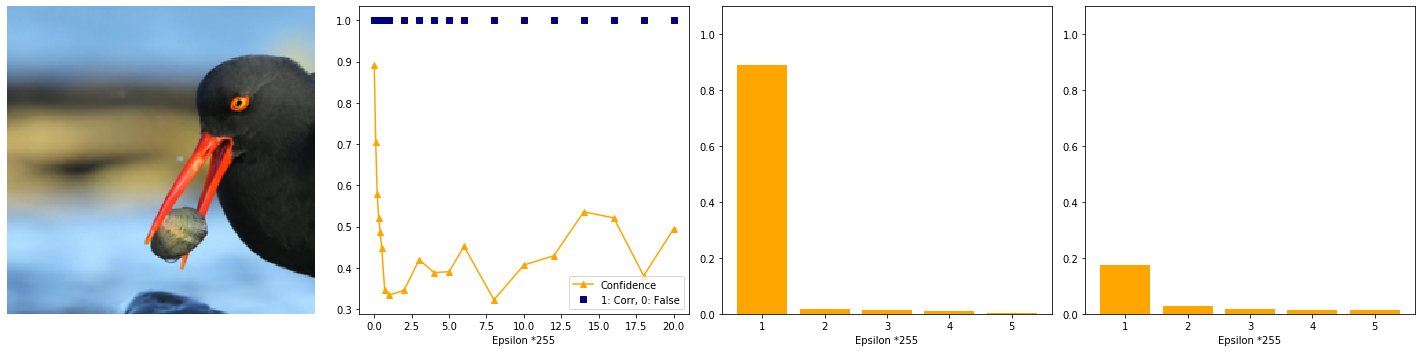

In [16]:
sample = 323
epsilon_conf = 2/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

#### 2.1.2 Class bounces back

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.999767	barrel, cask
0.2			1	0.99909234	barrel, cask
0.3			1	0.99703383	barrel, cask
0.4			1	0.99310356	barrel, cask
0.5			1	0.98853755	barrel, cask
0.7			1	0.97121596	barrel, cask
1.0			1	0.9499181	barrel, cask
2.0			1	0.9599582	barrel, cask
3.0			1	0.9892208	barrel, cask
4.0			1	0.9529559	barrel, cask
5.0			1	0.83578336	barrel, cask
6.0			1	0.8285601	barrel, cask
8.0			1	0.7247472	barrel, cask
10.0			1	0.47900546	barrel, cask
12.0			1	0.72902167	barrel, cask
14.0			1	0.52684313	barrel, cask
16.0			0	0.21468204	lumbermill, sawmill
18.0			0	0.124735184	lumbermill, sawmill
20.0			0	0.1802558	lumbermill, sawmill


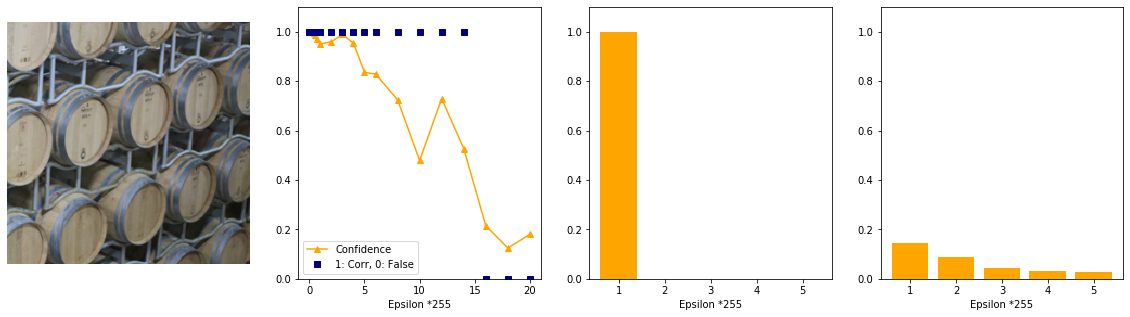

In [36]:
sample = 766
epsilon_conf = 3/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

In [ ]:
sample = 766
epsilon_conf = 4/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

In [ ]:
sample = 766
epsilon_conf = 5/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

In [ ]:
sample = 766
epsilon_conf = 18/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.89812696	apron
0.1			1	0.64871854	apron
0.2			1	0.46519157	apron
0.3			1	0.38934562	apron
0.4			1	0.34077898	apron
0.5			1	0.32502708	apron
0.7			1	0.27854213	apron
1.0			1	0.26864746	apron
2.0			1	0.10993061	apron
3.0			0	0.10986753	sweatshirt
4.0			1	0.117310785	apron
5.0			0	0.1602098	sweatshirt
6.0			0	0.20489548	sweatshirt
8.0			0	0.36606795	sweatshirt
10.0			0	0.19468589	sweatshirt
12.0			1	0.2728588	apron
14.0			0	0.38190392	sweatshirt
16.0			0	0.38336664	sweatshirt
18.0			0	0.5617563	sweatshirt
20.0			0	0.6086473	sweatshirt


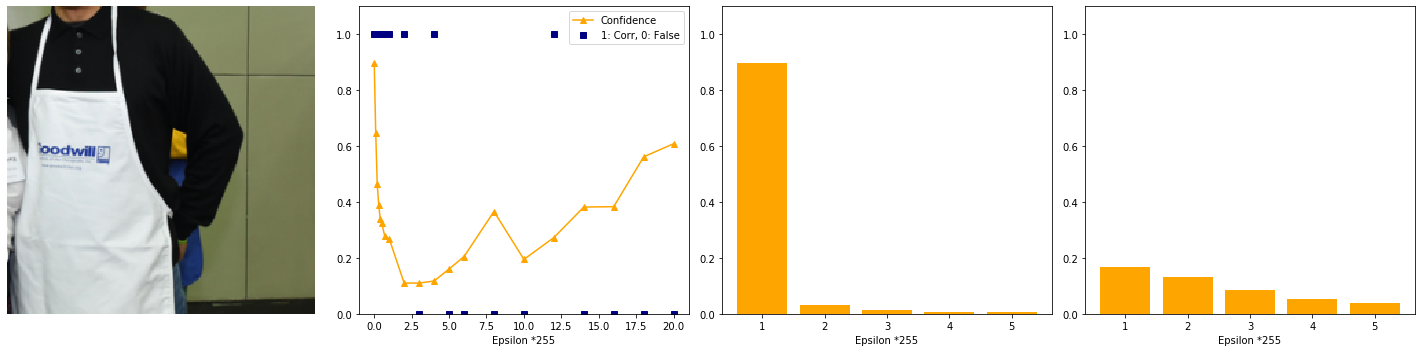

In [32]:
sample = 432
epsilon_conf = 0.5/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

#### 2.1.3 Adversarial confidence greater than initial confidence

In [ ]:
#--------> Find more examples!!!!!

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.49230596	umbrella
0.1			0	0.60616684	lionfish
0.2			0	0.7148238	lionfish
0.3			0	0.76434857	lionfish
0.4			0	0.75667536	lionfish
0.5			0	0.76683307	lionfish
0.7			0	0.7306541	lionfish
1.0			0	0.7817947	lionfish
2.0			0	0.7758732	lionfish
3.0			0	0.776687	lionfish
4.0			0	0.79604566	lionfish
5.0			0	0.86716855	lionfish
6.0			0	0.77817774	lionfish
8.0			0	0.9382566	lionfish
10.0			0	0.88319385	lionfish
12.0			0	0.7447567	lionfish
14.0			0	0.6037736	lionfish
16.0			0	0.68483675	lionfish
18.0			0	0.74503297	lionfish
20.0			0	0.4969511	lionfish


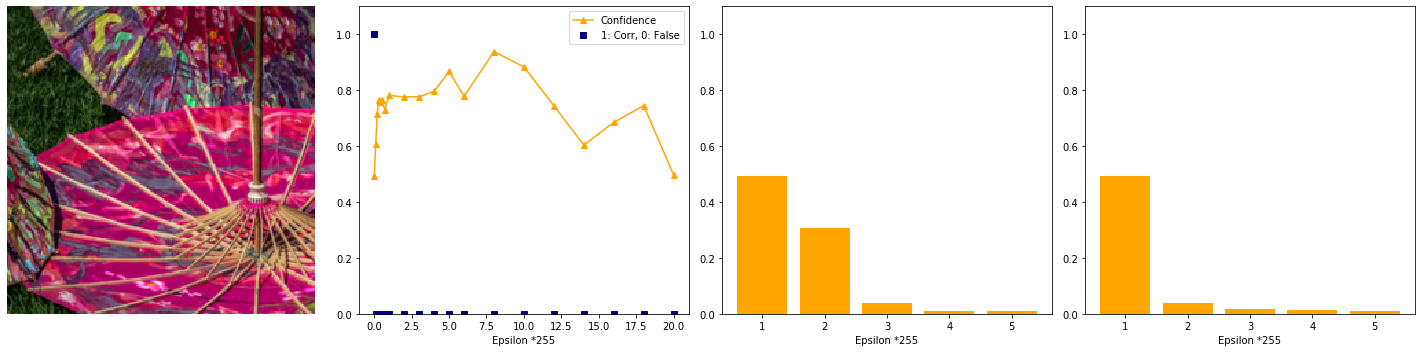

In [39]:
sample = 258
epsilon_conf = 8/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

# Confidence up to 94% for wrong class at epsilon=8

## Some old stuff!!!!!

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.999767	barrel, cask
0.2			1	0.99909234	barrel, cask
0.3			1	0.99703383	barrel, cask
0.4			1	0.99310356	barrel, cask
0.5			1	0.98853755	barrel, cask
0.7			1	0.97121596	barrel, cask
1.0			1	0.9499181	barrel, cask
2.0			1	0.9599582	barrel, cask
3.0			1	0.9892208	barrel, cask
4.0			1	0.9529559	barrel, cask
5.0			1	0.83578336	barrel, cask
6.0			1	0.8285601	barrel, cask
8.0			1	0.7247472	barrel, cask
10.0			1	0.47900546	barrel, cask
12.0			1	0.72902167	barrel, cask
14.0			1	0.52684313	barrel, cask
16.0			0	0.21468204	lumbermill, sawmill
18.0			0	0.124735184	lumbermill, sawmill
22.0			0	0.13377748	lumbermill, sawmill
26.0			0	0.28896436	honeycomb
32.0			0	0.81656784	honeycomb
40.0			0	0.53247404	brain coral


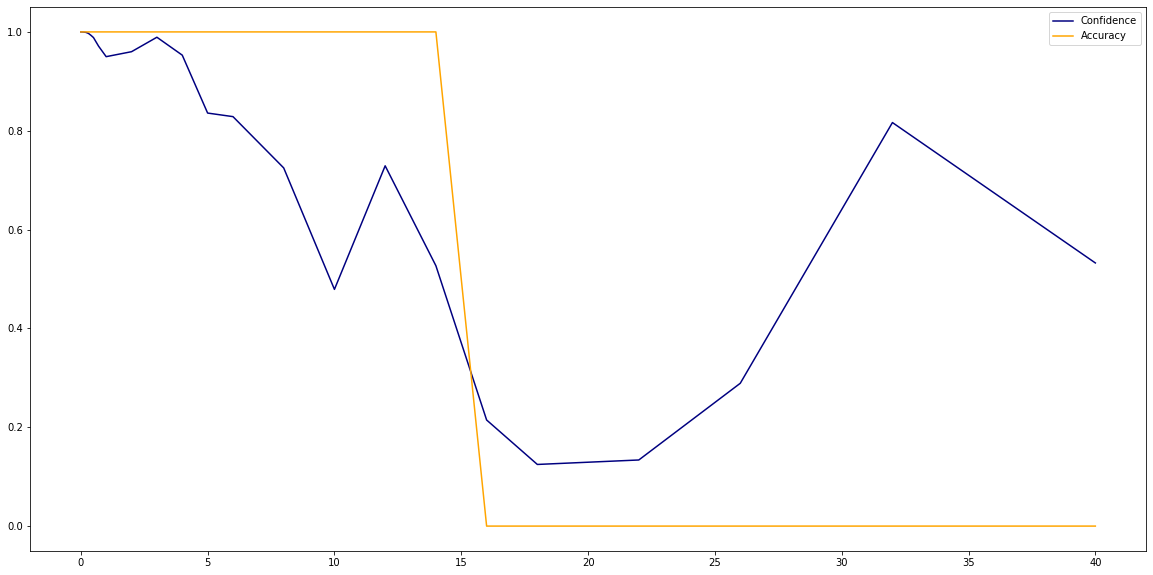

In [98]:
iterate_epsilons(766)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997663	barrel, cask
0.2			1	0.9991203	barrel, cask
0.3			1	0.9973918	barrel, cask
0.4			1	0.9938798	barrel, cask
0.5			1	0.98826796	barrel, cask
0.7			1	0.95988446	barrel, cask
1.0			1	0.9368711	barrel, cask
2.0			1	0.85285	barrel, cask
3.0			1	0.42362154	barrel, cask
4.0			1	0.32486832	barrel, cask
5.0			1	0.587586	barrel, cask
6.0			1	0.23409425	barrel, cask
8.0			0	0.093663804	lumbermill, sawmill
10.0			0	0.10282399	lumbermill, sawmill
12.0			0	0.21646465	lumbermill, sawmill
14.0			0	0.098761804	lumbermill, sawmill
16.0			0	0.17943078	lumbermill, sawmill
18.0			0	0.10978956	lumbermill, sawmill
22.0			0	0.14064844	boa constrictor, Constrictor constrictor
26.0			0	0.14764187	honeycomb
32.0			0	0.8395479	honeycomb
40.0			0	0.094081685	tarantula


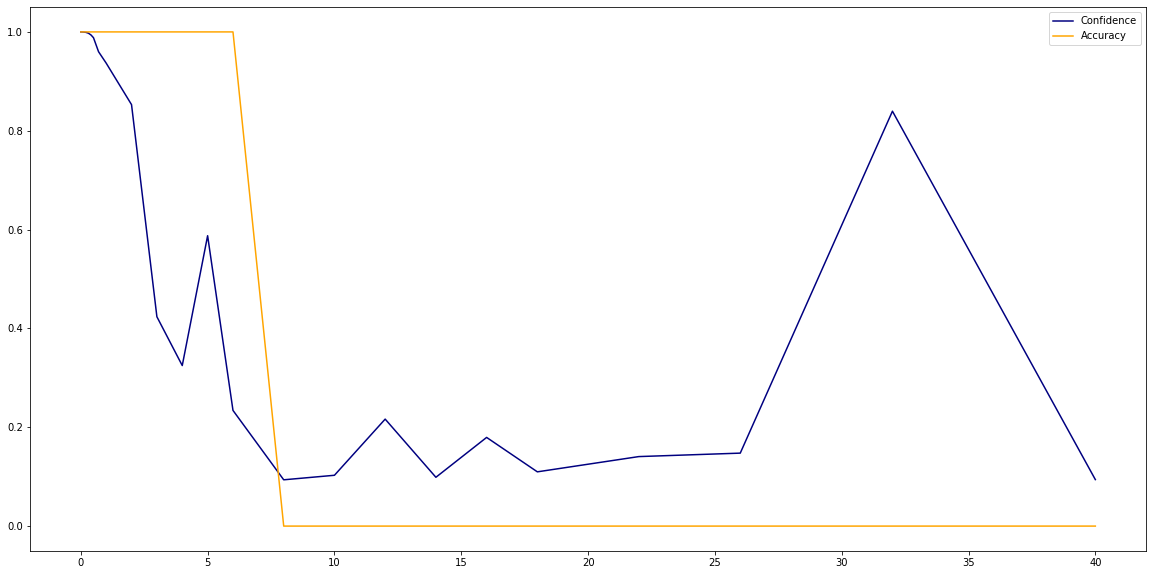

In [102]:
iterate_epsilons(766)

Epsilon 	 Accuracy 	 Confidence 	 Label
2.5500000000000003			1	0.58938587	dial telephone, dial phone
0.1			1	0.9988556	dial telephone, dial phone
0.2			1	0.9970053	dial telephone, dial phone
0.3			1	0.9936346	dial telephone, dial phone
0.4			1	0.9883478	dial telephone, dial phone
0.5			1	0.9809203	dial telephone, dial phone
0.7			1	0.959067	dial telephone, dial phone
1.0			1	0.90892076	dial telephone, dial phone
2.0			1	0.6984587	dial telephone, dial phone
3.0			1	0.52429956	dial telephone, dial phone
4.0			1	0.4055124	dial telephone, dial phone
5.0			1	0.35374087	dial telephone, dial phone
6.0			1	0.35036153	dial telephone, dial phone
8.0			1	0.33643234	dial telephone, dial phone
10.0			1	0.30700144	dial telephone, dial phone
12.0			0	0.2909409	spindle
14.0			0	0.32932037	spindle
16.0			0	0.27878878	spindle
18.0			0	0.20404696	spindle
22.0			0	0.14253508	spindle
26.0			0	0.09459376	spindle
32.0			0	0.04435969	spindle
40.0			0	0.02793514	scorpion


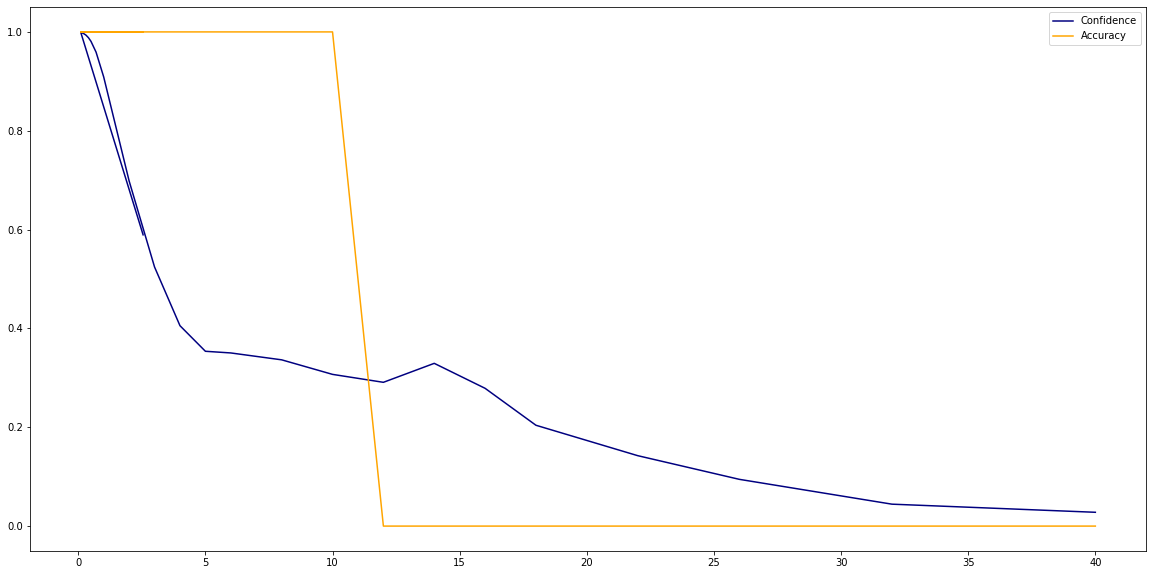

In [47]:
iterate_epsilons(590)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.99721515	honeycomb
0.2			1	0.9936559	honeycomb
0.3			1	0.98548675	honeycomb
0.4			1	0.9702776	honeycomb
0.5			1	0.94641435	honeycomb
0.7			1	0.87577116	honeycomb
1.0			1	0.7662984	honeycomb
2.0			1	0.6421063	honeycomb
3.0			1	0.6387259	honeycomb
4.0			1	0.63160247	honeycomb
5.0			1	0.64614445	honeycomb
6.0			1	0.68201077	honeycomb
8.0			1	0.80579555	honeycomb
10.0			1	0.9198083	honeycomb
12.0			1	0.9653693	honeycomb
14.0			1	0.9822119	honeycomb
16.0			1	0.9883703	honeycomb
18.0			1	0.99088913	honeycomb
22.0			1	0.99439573	honeycomb
26.0			1	0.99641454	honeycomb
32.0			1	0.99756575	honeycomb
40.0			1	0.997715	honeycomb


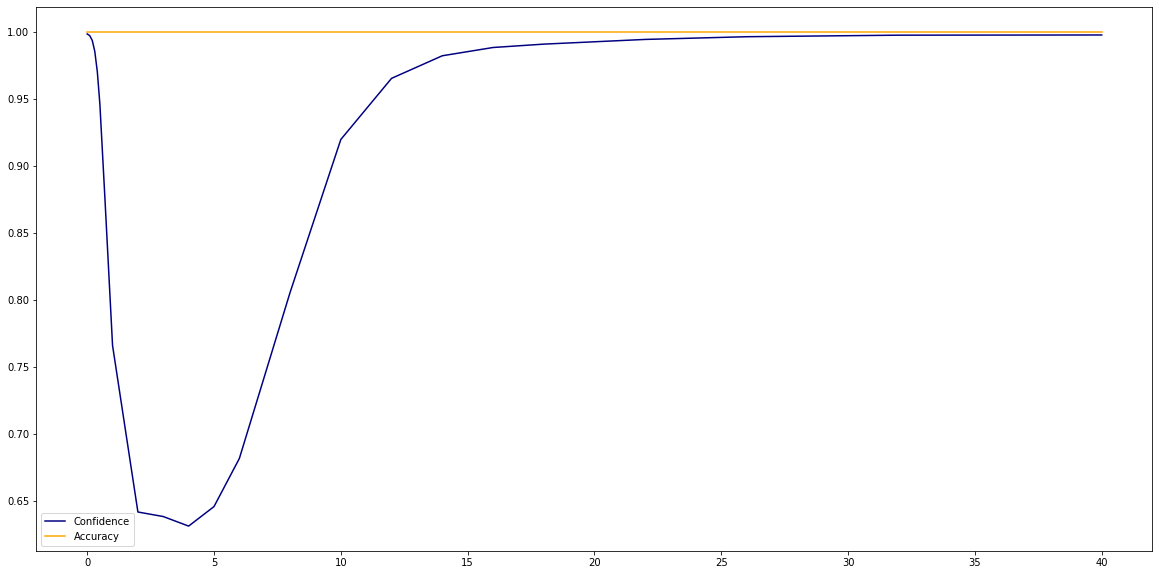

In [75]:
iterate_epsilons(132)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9978678	baseball
0.1			1	0.99073595	baseball
0.2			1	0.9740122	baseball
0.3			1	0.9442655	baseball
0.4			1	0.8999622	baseball
0.5			1	0.8442669	baseball
0.7			1	0.726144	baseball
1.0			1	0.58897096	baseball
2.0			1	0.35198572	baseball
3.0			1	0.24360058	baseball
4.0			1	0.18754263	baseball
5.0			1	0.15972885	baseball
6.0			1	0.14501931	baseball
8.0			1	0.11653368	baseball
10.0			1	0.13254663	baseball
12.0			1	0.16315761	baseball
14.0			1	0.19640179	baseball
16.0			1	0.2417866	baseball
18.0			1	0.2595709	baseball
22.0			1	0.2806484	baseball
26.0			1	0.24594808	baseball
32.0			1	0.18234633	baseball
40.0			0	0.21733066	poncho


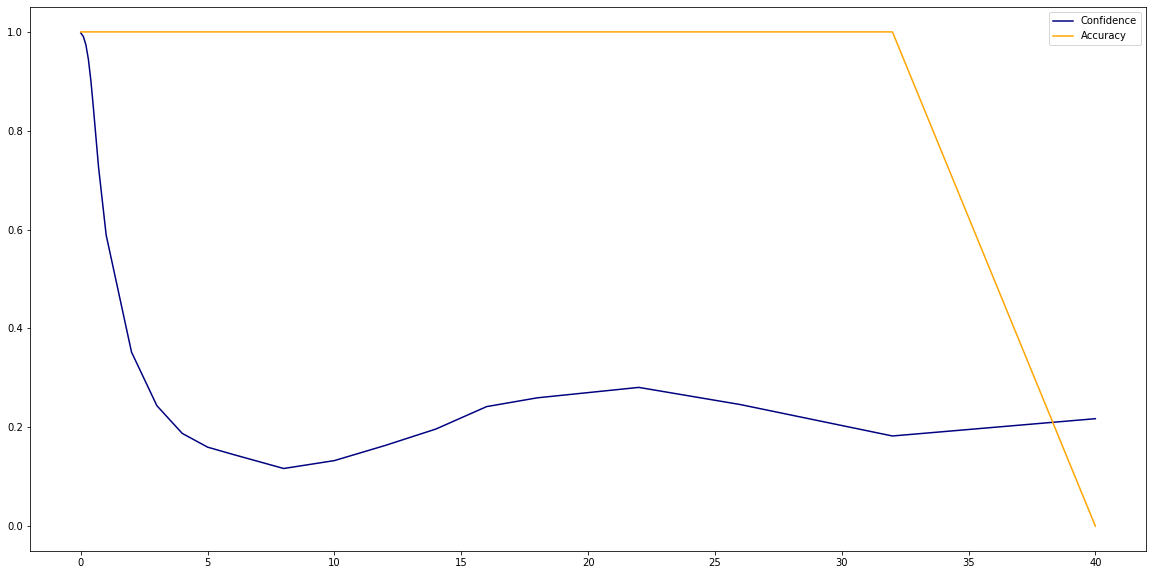

In [76]:
iterate_epsilons(241)

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*